In [1]:
import matplotlib.pyplot as plt
from pickle import dump, load
import pandas as pd
import numpy as np
from scipy.spatial.distance import euclidean
import sys
import gurobipy as gb
from source import *

import os

path = os.getcwd()
cd = 0.041
cw = 0.0388

In [3]:

stations = pd.read_csv(path+"/Data/Definite Stations.csv",index_col=[0])
vehicles = pd.read_csv(path+"/Data/Definite Vehicles.csv",index_col=[0])

# Model

In [5]:
file = open(path+"/Data/S", "rb"); S = load(file); file.close()
file = open(path+"/Data/c_s", "rb"); c_s = load(file); file.close()

print(len(S))

1083


In [4]:

objs = {}
for sc in range(25):

    K = {}; S_k = {}; K_s = {}
    for sc1 in range(25):
        file = open(path+f"K/K_sc{sc1}", "rb")
        K[sc1] = load(file); file.close()

        file = open(path+f"S_k10/Sk_sc{sc1}", "rb")
        S_k[sc1] = load(file); file.close()    

        file = open(path+f"K_s10/Ks_sc{sc1}", "rb")
        K_s[sc1] = load(file); file.close()
    

    print(f"Running for scenario {sc}")
    m = gb.Model("First Stage")

    theta = {s:m.addVar(name=f"theta_{s}",vtype=gb.GRB.BINARY) for s in S}

    m.addConstr(gb.quicksum(theta[s] for s in S) == 600)

    for sc1 in range(25):
        for k in K[sc1]:
            m.addConstr(gb.quicksum(theta[s] for s in S_k[sc1][k]) >= 1)

    m.setObjective(gb.quicksum(c_s[s]*theta[s] for s in S))
    m.setParam("OutputFlag",0)

    i = 0; objs[sc] = dict(); last_cdw = 1e5
    while True:
        m.update()
        m.optimize()

        print(f"\tTrying for configuration {i}, with cost {round(100*(m.getObjective().getValue()/4217.75-1),2)}% higher"); i += 1
        
        open_stations = [s for s in S if theta[s].X>0.5]

        y = {s:8 for s in open_stations}; T = 5

        K, K_s, S_k, a, t = load_pickle(path,sc)
        S_k = {k:[s for s in S_k[k] if s in open_stations] for k in K}
        a.update({("s",s):0 for s in open_stations})
        a.update({("e",s):30 for s in open_stations})
        t.update({("s",s):0 for s in open_stations})
        t.update({("e",s):0 for s in open_stations})

        objs[sc][i] = second_stage_ESPP(open_stations,K,K_s,S_k,T,y,a,t)
        
        if i > 30: break
        m.addConstr(gb.quicksum(c_s[s]*theta[s] for s in S) >= 4217.75*(1+0.0025*i))
        
        

Running for scenario 0
Set parameter Username
Academic license - for non-commercial use only - expires 2024-04-07
	Trying for configuration 0, with cost 0.0% higher
		Iteration 0:		MP obj: 4591.0	time: 0.02s
		Iteration 1:		MP obj: 80.0	time: 40.25s
		Iteration 2:		MP obj: 26.8	time: 42.33s
		Iteration 3:		MP obj: 23.0	time: 42.64s
		Iteration 4:		MP obj: 22.0	time: 42.97s
		Iteration 5:		MP obj: 22.0	time: 43.23s
		Iteration 6:		MP obj: 22.0	time: 43.5s
		Iteration 7:		MP obj: 21.8	time: 43.81s
		Iteration 8:		MP obj: 21.19	time: 44.17s
		Iteration 9:		MP obj: 20.81	time: 44.67s
		Iteration 10:		MP obj: 20.38	time: 45.14s
		Iteration 11:		MP obj: 20.06	time: 45.52s
		Iteration 12:		MP obj: 19.76	time: 45.84s
		Iteration 13:		MP obj: 19.48	time: 46.23s
		Iteration 14:		MP obj: 19.11	time: 46.62s
		Iteration 15:		MP obj: 18.56	time: 47.02s
		Iteration 16:		MP obj: 18.16	time: 47.47s
		Iteration 17:		MP obj: 17.85	time: 47.94s
		Iteration 18:		MP obj: 17.36	time: 48.56s
		Iteration 19:		

In [9]:
file = open(path+"/Results/Feasible_Configurations","wb")
dump(objs,file); file.close()

In [6]:
open_stations = {}; stress_index = {}; cdw = {}; coverage = {}

K = {}; S_k = {}; K_s = {}
for sc1 in range(25):
    file = open(path+f"/Data/K/K_sc{sc1}", "rb")
    K[sc1] = load(file); file.close()

    file = open(path+f"/Data/S_k10/Sk_sc{sc1}", "rb")
    S_k[sc1] = load(file); file.close()    

    file = open(path+f"/Data/K_s10/Ks_sc{sc1}", "rb")
    K_s[sc1] = load(file); file.close()

m = gb.Model("First Stage")

theta = {s:m.addVar(name=f"theta_{s}",vtype=gb.GRB.BINARY) for s in S}

m.addConstr(gb.quicksum(theta[s] for s in S) == 600)
for sc1 in range(25):
    for k in K[sc1]:
        m.addConstr(gb.quicksum(theta[s] for s in S_k[sc1][k]) >= 1)

m.setObjective(gb.quicksum(c_s[s]*theta[s] for s in S))
m.setParam("OutputFlag",0)

for i in range(31):

    m.update()
    m.optimize()

    open_stations[i] = [s for s in S if theta[s].X > 0.5]
    stress_index[i] = {sc:{s:len(K_s[sc][s]) for s in open_stations[i]} for sc in range(25)}
    cdw[i] = m.getObjective().getValue()
    coverage[i] = {sc:np.mean(np.array([len([s for s in S_k[sc][k] if s in open_stations[i]]) for k in K[sc]])) for sc in range(25)}

    m.addConstr(gb.quicksum(c_s[s]*theta[s] for s in S) >= 4217.75*(1+0.0025*i))

    

Set parameter Username
Academic license - for non-commercial use only - expires 2024-01-08


In [7]:
path_results = "C:/Users/a.rojasa55/OneDrive - Universidad de los Andes/Documentos/MOPTA-23/Results/"

for i in range(31):
    file = open(path + f"/Results/Configurations/Open Stations/open_stations_{i}", "wb")
    dump(open_stations[i],file); file.close()

    file = open(path + f"/Results/Configurations/Stress Index/stress_index_{i}", "wb")
    dump(stress_index[i],file); file.close()

    file = open(path + f"/Results/Configurations/Costs/driving_charging_cost_{i}", "wb")
    dump(cdw[i], file); file.close()

    file = open(path + f"/Results/Configurations/Coverage/coverage_{i}", "wb")
    dump(coverage[i], file); file.close()

In [7]:
path

'C:/Users/a.rojasa55/OneDrive - Universidad de los Andes/Documentos/MOPTA-23/Data/'

In [5]:
open_stations

{0: [5,
  6,
  9,
  10,
  12,
  13,
  14,
  16,
  19,
  22,
  24,
  27,
  35,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  45,
  46,
  47,
  48,
  50,
  51,
  52,
  53,
  54,
  55,
  57,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  68,
  71,
  74,
  76,
  78,
  79,
  81,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  91,
  94,
  96,
  98,
  101,
  104,
  109,
  110,
  111,
  120,
  125,
  139,
  141,
  145,
  147,
  148,
  150,
  151,
  154,
  155,
  157,
  158,
  160,
  161,
  162,
  163,
  164,
  170,
  177,
  183,
  190,
  191,
  192,
  193,
  195,
  197,
  198,
  199,
  200,
  201,
  207,
  208,
  209,
  219,
  220,
  221,
  222,
  223,
  225,
  228,
  229,
  230,
  231,
  232,
  233,
  234,
  235,
  239,
  240,
  241,
  244,
  247,
  248,
  249,
  250,
  254,
  255,
  260,
  262,
  263,
  267,
  268,
  270,
  271,
  273,
  274,
  279,
  280,
  281,
  284,
  289,
  290,
  292,
  293,
  294,
  295,
  296,
  297,
  299,
  300,
  301,
  302,
  303,
  305,
  306,
  307,
  308,
  309,
  312,

In [6]:
def plot_solution(it,show_vehic=True,show_infeas=True,show_stat=True,show_stressed=True):
        img = plt.imread("./Problem Visualization/Pennsylvania_Population.png")
        fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(18,12))

        if show_vehic:
                for v in vehicles.index:
                        x_v = vehicles.loc[v,"0"]; y_v = vehicles.loc[v,"1"]
                        ax.plot(x_v,y_v,marker="o",color="darkgreen")

        if show_stat:
                for s in stations.index:
                        x_v = stations.loc[s,"0"]; y_v = stations.loc[s,"1"]
                        ax.plot(x_v,y_v,marker="o",color="maroon")

                for s in played[it]:
                        x_v = stations.loc[s,"0"]; y_v = stations.loc[s,"1"]
                        ax.plot(x_v,y_v,marker="o",color="darkorange")

        if show_infeas:
                for v in play[it][1]:
                        x_v = vehicles.loc[v,"0"]; y_v = vehicles.loc[v,"1"]
                        ax.plot(x_v,y_v,marker="o",color="red")

        if show_stressed:
                for s in open_stations:
                        if len(K_s[s]) > 100:
                                x_v = stations.loc[s,"0"]; y_v = stations.loc[s,"1"]
                                ax.plot(x_v,y_v,marker="o",color="magenta")

        ax.plot([-30],[-30],marker="o",linestyle="",color="maroon",label="unopened stations")
        ax.plot([-30],[-30],marker="o",linestyle="",color="darkorange",label="open stations")
        ax.plot([-30],[-30],marker="o",linestyle="",color="magenta",label="open stations > 100 vehic.")
        ax.plot([-30],[-30],marker="o",linestyle="",color="darkgreen",label="assigned vehicles")
        ax.plot([-30],[-30],marker="o",linestyle="",color="red",label="unassigned vehicles")

        ax.legend(loc="upper right")

        ax.vlines(x=[0,290],ymin=0,ymax=150,color="black")
        ax.hlines(y=[0,150],xmin=0,xmax=290,color="black")

        ax.spines[["top","bottom","left","right"]].set_visible(False)

        zero = (-5,-5)
        height = 184.425
        ax.imshow(img, extent=[zero[0], zero[0]+height*5/3, zero[1], zero[1]+height])
        
        ax.set_xlim(-20,320)
        ax.set_ylim(-20,190)
        ax.set_xticks([]); ax.set_yticks([])

In [7]:
file = open("C:/Users/a.rojasa55/OneDrive - Universidad de los Andes/Documentos/MOPTA-23/Results/Feasible_Configurations","wb")
pickle.dump(objs,file); file.close()

In [ ]:
for it in [1,10,13,14,16]:
    plot_solution(it)

In [ ]:
plot_solution(0,show_vehic=True,show_infeas=False,show_stat=False,show_stressed=False)

In [ ]:
plt.boxplot([len(K_s[s]) for s in open_stations],positions=[0])
plt.boxplot([len(K_s[s]) for s in S],positions=[1])
print(f"{sum(1 if len(K_s[s]) > 100 else 0 for s in open_stations)} open stations have more than 100 possible vehicles to be assigned, out of {sum(1 if len(K_s[s]) > 100 else 0 for s in S)} stations in total")

# Second Model

In [3]:
file = open(path+"S", "rb"); S = load(file); file.close()
file = open(path+"c_s", "rb"); c_s = load(file); file.close()

K = {}; S_k = {}; K_s = {}
for sc in range(25):
    file = open(path+f"K/K_sc{sc}", "rb")
    K[sc] = load(file); file.close()

    file = open(path+f"S_k10/Sk_sc{sc}", "rb")
    S_k[sc] = load(file); file.close()    

    file = open(path+f"K_s10/Ks_sc{sc}", "rb")
    K_s[sc] = load(file); file.close()

In [4]:
m = gb.Model("First Stage")

theta = {s:m.addVar(name=f"theta_{s}",vtype=gb.GRB.BINARY) for s in S}
zz = m.addVar(name="z",vtype=gb.GRB.CONTINUOUS)

m.addConstr(gb.quicksum(theta[s] for s in S) == 600)

for sc in range(25):
    for k in K[sc]:
        m.addConstr(gb.quicksum(theta[s] for s in S_k[sc][k]) >= 1)
    for s in S:
        m.addConstr(zz >= theta[s]*len(K_s[sc][s]))

#m.setObjective(gb.quicksum(c_s[s]*theta[s] for s in S))
m.setObjective(zz)

m.update()
#m.setParam("OutputFlag",0)
m.optimize()

Set parameter Username
Academic license - for non-commercial use only - expires 2024-04-07
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: 12th Gen Intel(R) Core(TM) i7-1265U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 143550 rows, 1217 columns and 1189014 nonzeros
Model fingerprint: 0xaeca69f5
Variable types: 1 continuous, 1216 integer (1216 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+02]
Found heuristic solution: objective 216.0000000
Presolve removed 142505 rows and 436 columns
Presolve time: 1.44s
Presolved: 1045 rows, 781 columns, 8207 nonzeros
Variable types: 0 continuous, 781 integer (650 binary)
Found heuristic solution: objective 215.0000000

Root relaxation: objective 8.266358e+01, 472 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    C

## Open Stations Plotting

In [7]:
open_stations = [s for s in S if theta[s].X>0.5]
new_cost = sum(c_s[s] for s in open_stations)
print(new_cost/4217.75)

1.4469664254957604


## Feasibility check

In [19]:
objs = {}
sc = 0
print(f"Running for scenario {sc}")
y = {s:8 for s in open_stations}

K, K_s, S_k, a, t = load_pickle(path,sc)
S_k = {k:[s for s in S_k[k] if s in open_stations] for k in K}
a.update({("s",s):0 for s in open_stations})
a.update({("e",s):10 for s in open_stations})
t.update({("e",s):0 for s in open_stations})

objs[sc] = second_stage_ESPP(open_stations,K,K_s,S_k,2,y,a,t)
print(f"Final result for scenario {sc}: {objs[sc]} infeasible vehicles\n")

Running for scenario 0
Iteration 0:	4590 infeasible vehicles	MP obj: 4590.0	time: 0.03s
Iteration 1:	3818 infeasible vehicles	MP obj: 3818.0	time: 31.42s
Iteration 2:	2873 infeasible vehicles	MP obj: 2872.0	time: 70.19s
Iteration 3:	2184 infeasible vehicles	MP obj: 2184.0	time: 96.48s
Iteration 4:	1865 infeasible vehicles	MP obj: 1856.0	time: 111.98s
Iteration 5:	1787 infeasible vehicles	MP obj: 1780.0	time: 120.02s
Iteration 6:	1770 infeasible vehicles	MP obj: 1760.0	time: 123.06s
Iteration 7:	1765 infeasible vehicles	MP obj: 1754.0	time: 125.19s
Iteration 8:	1762 infeasible vehicles	MP obj: 1751.0	time: 127.88s
Final result for scenario 0: (1751.0, [8192, 8198, 8202, 8205, 8212, 8214, 8215, 8219, 8224, 8225, 8234, 8236, 46, 8238, 8242, 8246, 8249, 8251, 8254, 8263, 8266, 78, 8269, 8274, 8277, 8281, 8289, 100, 8291, 8321, 8322, 8328, 8331, 138, 8334, 145, 146, 155, 8350, 8354, 8359, 8360, 8375, 8385, 8399, 8404, 8405, 214, 8411, 8412, 8415, 8421, 8422, 8425, 8431, 8440, 8445, 8446, 84

[]

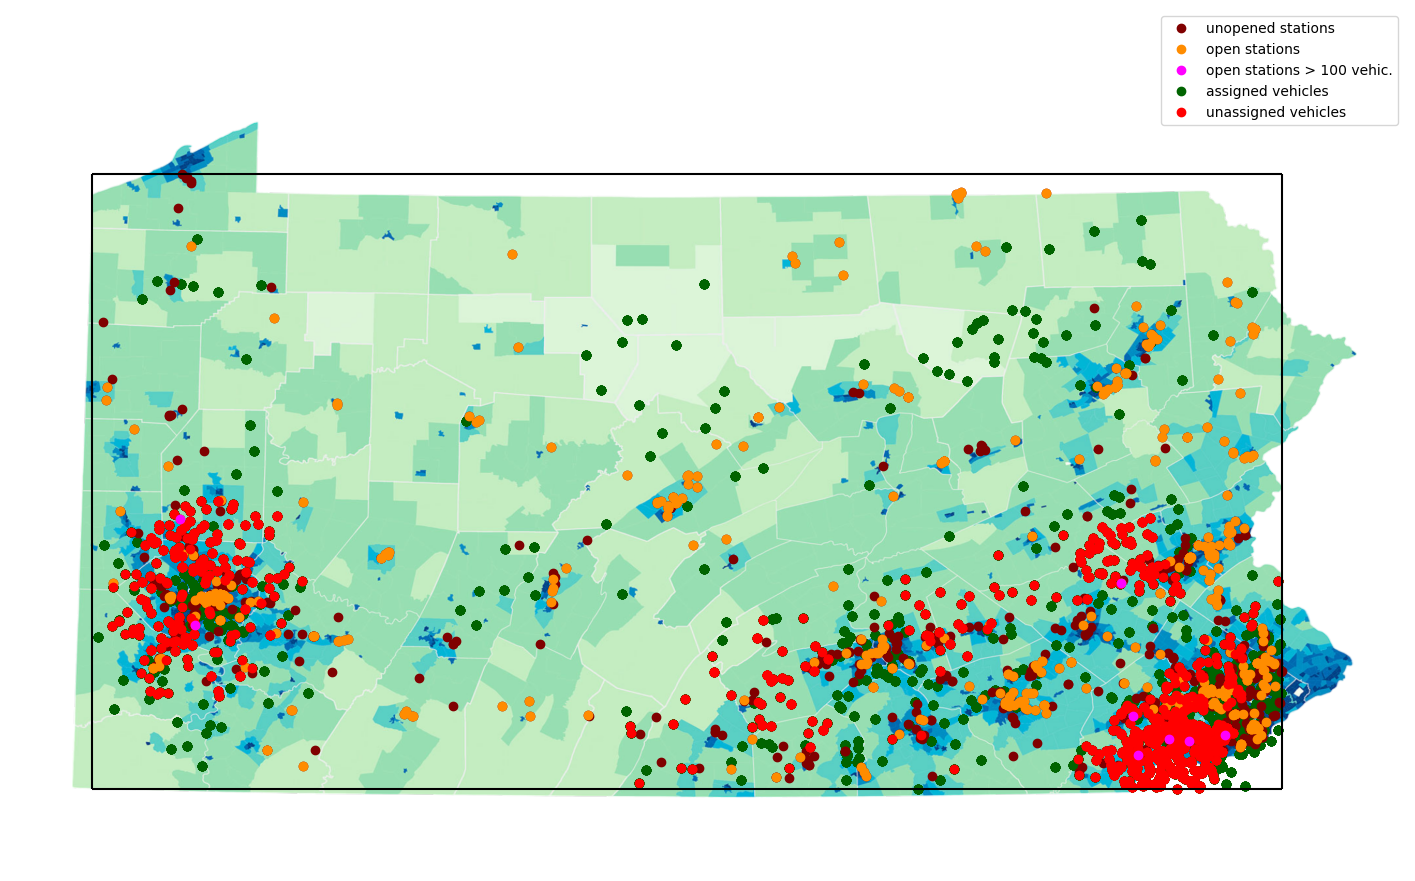

In [20]:
img = plt.imread("./Problem Visualization/Pennsylvania_Population.png")
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(18,12))

for v in vehicles.index:
        x_v = vehicles.loc[v,0]; y_v = vehicles.loc[v,1]
        ax.plot(x_v,y_v,marker="o",color="darkgreen")

for s in stations.index:
        x_v = stations.loc[s,0]; y_v = stations.loc[s,1]
        ax.plot(x_v,y_v,marker="o",color="maroon")

for s in open_stations:
        x_v = stations.loc[s,0]; y_v = stations.loc[s,1]
        ax.plot(x_v,y_v,marker="o",color="darkorange")

for v in objs[0][1]:
        x_v = vehicles.loc[v,0]; y_v = vehicles.loc[v,1]
        ax.plot(x_v,y_v,marker="o",color="red")

for s in open_stations:
        if len(K_s[s]) > 100:
                x_v = stations.loc[s,0]; y_v = stations.loc[s,1]
                ax.plot(x_v,y_v,marker="o",color="magenta")

ax.plot([-30],[-30],marker="o",linestyle="",color="maroon",label="unopened stations")
ax.plot([-30],[-30],marker="o",linestyle="",color="darkorange",label="open stations")
ax.plot([-30],[-30],marker="o",linestyle="",color="magenta",label="open stations > 100 vehic.")
ax.plot([-30],[-30],marker="o",linestyle="",color="darkgreen",label="assigned vehicles")
ax.plot([-30],[-30],marker="o",linestyle="",color="red",label="unassigned vehicles")

ax.legend(loc="upper right")

ax.vlines(x=[0,290],ymin=0,ymax=150,color="black")
ax.hlines(y=[0,150],xmin=0,xmax=290,color="black")

ax.spines[["top","bottom","left","right"]].set_visible(False)

#ax.imshow(img, extent=[-5, 308, -5, 178])
ax.imshow(img, extent=[-5, 308, -5, 165])
#ax.legend(loc="upper right")
ax.set_xlim(-20,320)
ax.set_ylim(-20,190)
ax.set_xticks([]); ax.set_yticks([])

8 open stations have more than 100 possible vehicles to be assigned, out of 77 stations in total


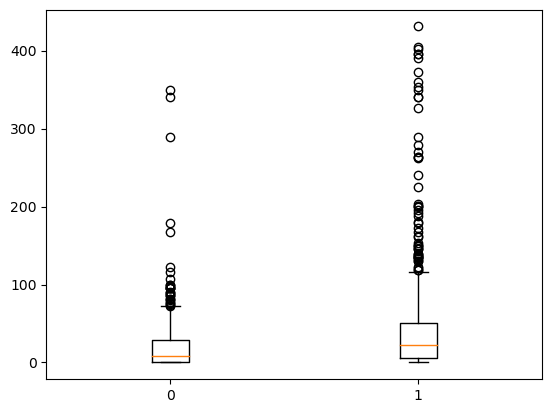

In [21]:
plt.boxplot([len(K_s[s]) for s in open_stations],positions=[0])
plt.boxplot([len(K_s[s]) for s in S],positions=[1])
print(f"{sum(1 if len(K_s[s]) > 100 else 0 for s in open_stations)} open stations have more than 100 possible vehicles to be assigned, out of {sum(1 if len(K_s[s]) > 100 else 0 for s in S)} stations in total")

# Third Model

In [23]:
file = open(path+"S", "rb"); S = load(file); file.close()
file = open(path+"c_s", "rb"); c_s = load(file); file.close()

K = {}; S_k = {}; K_s = {}
for sc in range(25):
    file = open(path+f"K/K_sc{sc}", "rb")
    K[sc] = load(file); file.close()

    file = open(path+f"S_k/Sk_sc{sc}", "rb")
    S_k[sc] = load(file); file.close()    

    file = open(path+f"K_s/Ks_sc{sc}", "rb")
    K_s[sc] = load(file); file.close()

In [24]:
m = gb.Model("First Stage")

theta = {s:m.addVar(name=f"theta_{s}",vtype=gb.GRB.BINARY) for s in S}
#zz = m.addVar(name="z",vtype=gb.GRB.CONTINUOUS)

m.addConstr(gb.quicksum(theta[s] for s in S) == 600)

for sc in range(25):
    for k in K[sc]:
        m.addConstr(gb.quicksum(theta[s] for s in S_k[sc][k]) >= 1)
    #for s in S:
    #    m.addConstr(zz >= theta[s]*len(K_s[sc][s]))

#m.setObjective(gb.quicksum(c_s[s]*theta[s] for s in S))
#m.setObjective(zz)
m.setObjective(gb.quicksum(theta[s]*len(K_s[sc][s]) for s in S))

m.update()
#m.setParam("OutputFlag",0)
m.optimize()

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: 12th Gen Intel(R) Core(TM) i7-1265U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 113296 rows, 1212 columns and 1132966 nonzeros
Model fingerprint: 0x2e77ba4a
Variable types: 0 continuous, 1212 integer (1212 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+00, 4e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+02]
Found heuristic solution: objective 18939.000000
Presolve removed 112540 rows and 429 columns
Presolve time: 0.73s
Presolved: 756 rows, 783 columns, 7447 nonzeros
Found heuristic solution: objective 9015.0000000
Variable types: 0 continuous, 783 integer (650 binary)
Found heuristic solution: objective 8988.0000000

Root relaxation: objective 7.265077e+03, 728 iterations, 0.02 seconds (0.02 work units)

    Nodes    |    Current Node    |     Objective Bounds    

## Open Stations Plotting

In [25]:
open_stations = [s for s in S if theta[s].X>0.5]

## Feasibility check

In [26]:
objs = {}
sc = 0
print(f"Running for scenario {sc}")
y = {s:8 for s in open_stations}

K, K_s, S_k, a, t = load_pickle(path,sc)
S_k = {k:[s for s in S_k[k] if s in open_stations] for k in K}
a.update({("s",s):0 for s in open_stations})
a.update({("e",s):10 for s in open_stations})
t.update({("e",s):0 for s in open_stations})

objs[sc] = second_stage_ESPP(open_stations,K,K_s,S_k,2,y,a,t)
print(f"Final result for scenario {sc}: {objs[sc]} infeasible vehicles\n")

Running for scenario 0
Iteration 0:	4590 infeasible vehicles	MP obj: 4590.0	time: 0.03s
Iteration 1:	3923 infeasible vehicles	MP obj: 3923.0	time: 17.75s
Iteration 2:	3175 infeasible vehicles	MP obj: 3175.0	time: 41.73s
Iteration 3:	2703 infeasible vehicles	MP obj: 2701.0	time: 51.2s
Iteration 4:	2586 infeasible vehicles	MP obj: 2583.0	time: 55.53s
Iteration 5:	2556 infeasible vehicles	MP obj: 2556.0	time: 57.06s
Iteration 6:	2552 infeasible vehicles	MP obj: 2552.0	time: 58.28s
Final result for scenario 0: (2552.0, [8192, 2, 8198, 8201, 8202, 8208, 8212, 8211, 8215, 8219, 8224, 8234, 8236, 46, 8238, 50, 8242, 8241, 8246, 8249, 8251, 59, 8254, 65, 8263, 8266, 78, 8269, 8264, 82, 85, 8274, 8277, 8281, 8284, 93, 8289, 8290, 99, 8291, 8300, 8302, 123, 8321, 8322, 8325, 8328, 8331, 138, 8334, 145, 146, 8337, 8343, 155, 8347, 8350, 8354, 8356, 8359, 8363, 173, 8360, 176, 8369, 8374, 185, 187, 8382, 8385, 8383, 196, 198, 201, 205, 8397, 8399, 8400, 8404, 8405, 8408, 8411, 8412, 8413, 8414, 84

[]

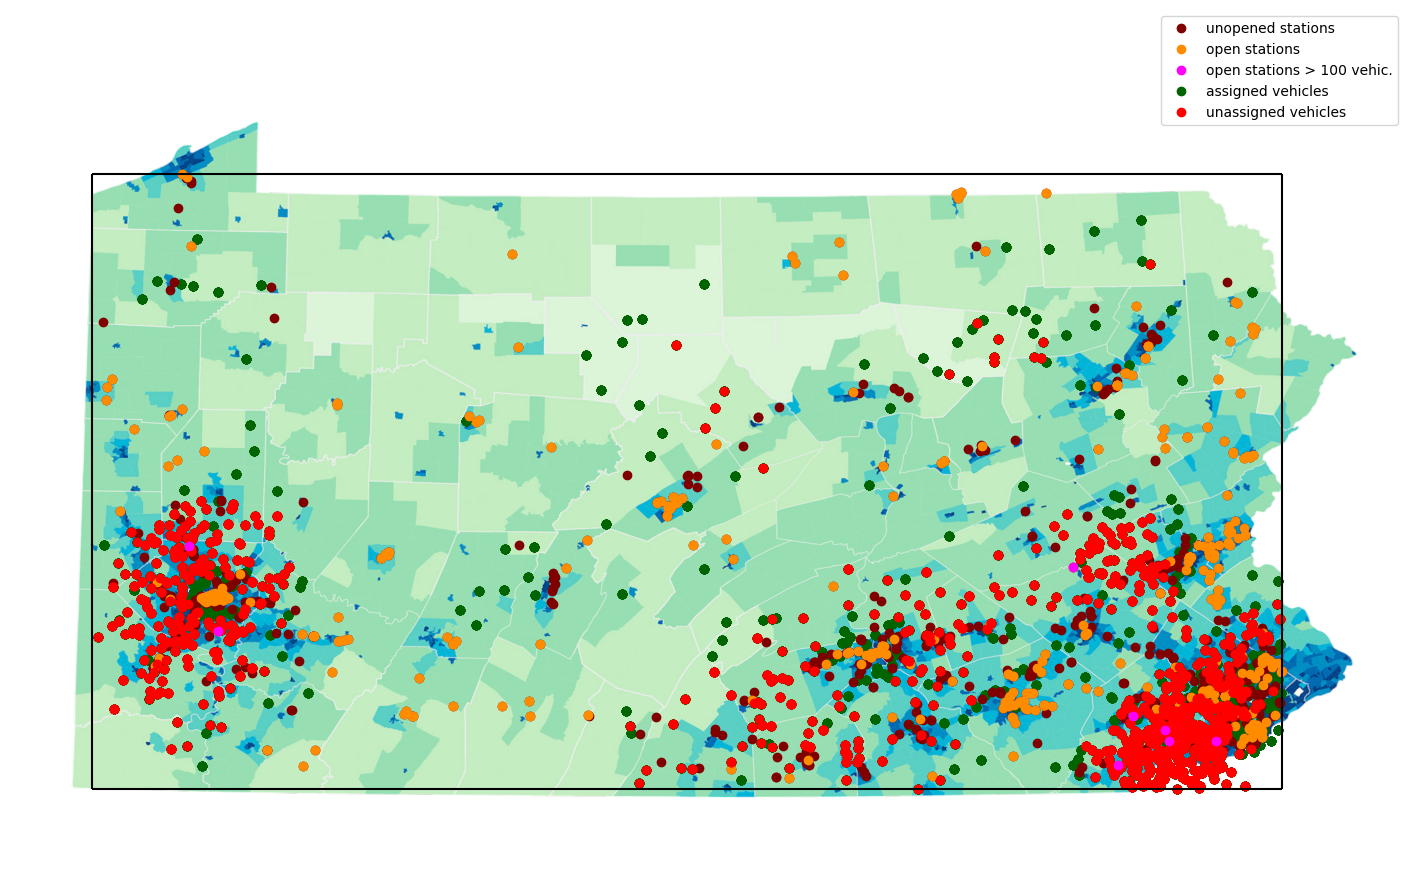

In [27]:
img = plt.imread("./Problem Visualization/Pennsylvania_Population.png")
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(18,12))

for v in vehicles.index:
        x_v = vehicles.loc[v,0]; y_v = vehicles.loc[v,1]
        ax.plot(x_v,y_v,marker="o",color="darkgreen")

for s in stations.index:
        x_v = stations.loc[s,0]; y_v = stations.loc[s,1]
        ax.plot(x_v,y_v,marker="o",color="maroon")

for s in open_stations:
        x_v = stations.loc[s,0]; y_v = stations.loc[s,1]
        ax.plot(x_v,y_v,marker="o",color="darkorange")

for v in objs[0][1]:
        x_v = vehicles.loc[v,0]; y_v = vehicles.loc[v,1]
        ax.plot(x_v,y_v,marker="o",color="red")

for s in open_stations:
        if len(K_s[s]) > 100:
                x_v = stations.loc[s,0]; y_v = stations.loc[s,1]
                ax.plot(x_v,y_v,marker="o",color="magenta")

ax.plot([-30],[-30],marker="o",linestyle="",color="maroon",label="unopened stations")
ax.plot([-30],[-30],marker="o",linestyle="",color="darkorange",label="open stations")
ax.plot([-30],[-30],marker="o",linestyle="",color="magenta",label="open stations > 100 vehic.")
ax.plot([-30],[-30],marker="o",linestyle="",color="darkgreen",label="assigned vehicles")
ax.plot([-30],[-30],marker="o",linestyle="",color="red",label="unassigned vehicles")

ax.legend(loc="upper right")

ax.vlines(x=[0,290],ymin=0,ymax=150,color="black")
ax.hlines(y=[0,150],xmin=0,xmax=290,color="black")

ax.spines[["top","bottom","left","right"]].set_visible(False)

#ax.imshow(img, extent=[-5, 308, -5, 178])
ax.imshow(img, extent=[-5, 308, -5, 165])
#ax.legend(loc="upper right")
ax.set_xlim(-20,320)
ax.set_ylim(-20,190)
ax.set_xticks([]); ax.set_yticks([])

8 open stations have more than 100 possible vehicles to be assigned, out of 77 stations in total


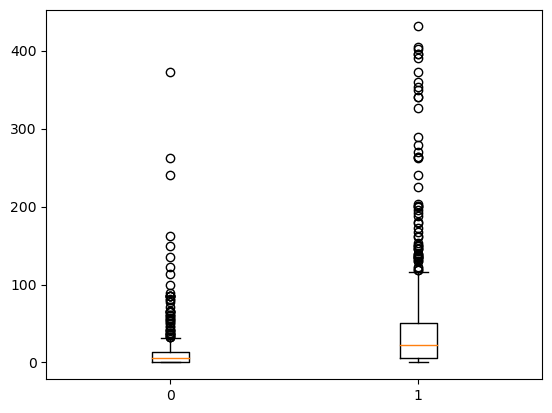

In [28]:
plt.boxplot([len(K_s[s]) for s in open_stations],positions=[0])
plt.boxplot([len(K_s[s]) for s in S],positions=[1])
print(f"{sum(1 if len(K_s[s]) > 100 else 0 for s in open_stations)} open stations have more than 100 possible vehicles to be assigned, out of {sum(1 if len(K_s[s]) > 100 else 0 for s in S)} stations in total")